# Machine Learning Online Class - Exercise 2: Logistic Regression

In [2]:
import numpy as np
from scipy.optimize import fmin_bfgs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3)

## ==================== Part 1: Plotting ====================

In [3]:
data = pd.read_csv("ex2data1.txt")
data.columns = ['score exam 1', 'score exam 2', 'adm']
data.head()

,score exam 1,score exam 2,adm
0,30.286711,43.894998,0
1,35.847409,72.902198,0
2,60.182599,86.308552,1
3,79.032736,75.344376,1
4,45.083277,56.316372,0


In [4]:
data['admitted'] = data['adm'].apply(lambda x : 'yes' if x==1 else 'no')
data.insert(0, 'x0', [1 for i in range(len(data.index))])
data

,x0,score exam 1,score exam 2,adm,admitted
0,1,30.286711,43.894998,0,no
1,1,35.847409,72.902198,0,no
2,1,60.182599,86.308552,1,yes
3,1,79.032736,75.344376,1,yes
4,1,45.083277,56.316372,0,no
...,...,...,...,...,...
94,1,83.489163,48.380286,1,yes
95,1,42.261701,87.103851,1,yes
96,1,99.315009,68.775409,1,yes
97,1,55.340018,64.931938,1,yes


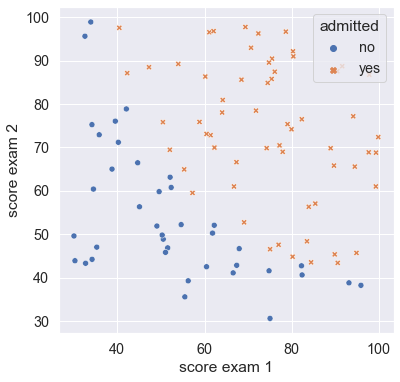

In [5]:
fig0, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, ax=ax, x='score exam 1', y='score exam 2', hue='admitted', style='admitted')

## ============ Part 2: Compute Cost and Gradient ============

In [6]:
#Extract matrix X and convert to array
X = data.iloc[:,0:3].to_numpy()
#Extract vector y as a column vector
y = data.iloc[:,3].to_numpy()[np.newaxis].T #create a new axis to convert a 1d array to 2d and transpose
X.shape, y.shape

((99, 3), (99, 1))

Cost function for the logistic regression
$$J(\vec{\theta})=-\frac{1}{m}\sum_{i=1}^m \left[y^{(i)}\log(h_{\theta}(\vec{x}^{(i)}))+(1-y^{(i)})\log(1-h_{\theta}(\vec{x}^{(i)}))\right],$$
with
$$h_{\theta}(\vec{x})=\frac{1}{1+e^{-\vec{x}^{(i)}\cdot\vec{\theta}}}.$$
We define the vector $\vec{h}_{\theta}(X)$ with components
$$h_{\theta}(X)^{(i)}=h_{\theta}(\vec{x}^{(i)}),$$
so that
$$J(\vec{\theta})=-\frac{1}{m}\left[\vec{y}^T\cdot\log(\vec{h}_{\theta}(X))+(\vec{1}-\vec{y})^T\cdot\log(\vec{1}-\vec{h}_{\theta}(X))\right],$$
where $\vec{1}$ is a column vector of 1s and the $\log(\cdot)$ operation is applied component-wise.<br ><br >
The components of the gradient of the cost function with respect to $\theta$ are
\begin{align}
\frac{\partial J}{\partial\theta_k}=&\frac{1}{m}\sum_{i=1}^m\left[h_{\theta}(\vec{x}^{(i)})-y^{(i)}\right]x^{(i)}_k\\
=&\frac{1}{m}\vec{x}_k^T\cdot\left[\vec{h}_{\theta}(X)-\vec{y}\right]
\end{align}

In [7]:
#Logistic function
def logistic(theta, x):
    dot = np.matmul(x, theta)
    if type(dot) == np.ndarray:
        dot = dot[0]
    return 1.0 / (1 + np.exp(-dot))

def hv(theta, X):
    return np.array([[logistic(theta, x) for x in X]]).T

#Cost function J
def J(theta, X, y):
    hvec = hv(theta.reshape(3,1), X)
    one = np.ones((y.shape[0],1))
    hvec1 = one-hvec
    logh = np.log(hvec)
    logh1 = np.log(hvec1)
    y1 = one-y
    
    dot1 = np.matmul(y.T,logh)
    dot2 = np.matmul(y1.T,logh1)
    return -(dot1[0][0]+dot2[0][0])/y.shape[0]

#Gradient of J
def grad_J(theta, X, y):
    hvec = hv(theta.reshape(3,1), X)
    yh = hvec - y
    grad = []
    for k in range(X.shape[1]):
        xk = X[:,k] #k column as 1d array (row vector)
        grad.append(np.matmul(xk,yh))
    return (np.asarray(grad)/y.shape[0]).flatten()

In [8]:
ini_theta = np.zeros(X.shape[1])#np.zeros((X.shape[1],1))

cost = J(ini_theta, X, y)
print("Cost at initial theta (zeros): {0:.3f}".format(cost))
print("Expected cost (approx): 0.693")

grad = grad_J(ini_theta, X, y)
print("Gradient at initial theta (zeros): ")
print(grad.tolist())
print("Expected gradients (approx): -0.1000, -12.0092, -11.2628")

Cost at initial theta (zeros): 0.693
Expected cost (approx): 0.693
Gradient at initial theta (zeros): 
[-0.10606060606060606, -12.305388775165389, -11.770672393525665]
Expected gradients (approx): -0.1000, -12.0092, -11.2628


In [9]:
test_theta = np.array([-24.0,0.2,0.2])

cost = J(test_theta, X, y)
print("Cost at test theta: {0:.3f}".format(cost))
print("Expected cost (approx): 0.218")

grad = grad_J(test_theta, X, y)
print("Gradient at test theta: ")
print(grad.tolist())
print("Expected gradients (approx): 0.043, 2.566, 2.647")

Cost at test theta: 0.218
Expected cost (approx): 0.218
Gradient at test theta: 
[0.041448555101244074, 2.526793010457438, 2.5262374189982175]
Expected gradients (approx): 0.043, 2.566, 2.647


## ============= Part 3: Gradient descent  =============

In [10]:
#gradient descent
def grad_desc(alpha, X, y, epochs, iprint):
    epoch = []
    history = []
    #Initializa parameter vector (fitting parameters)
    theta = np.zeros(X.shape[1])
    for e in range(epochs):
        theta = theta - alpha*grad_J(theta,X,y)
        if e%iprint == 0:
            epoch.append(e)
            history.append(J(theta,X,y))
    return theta, epoch, history

In [11]:
#Choose some alpha value
alpha = 0.005;
num_iters = 50000;

#Run gradient descent
theta, it, histo = grad_desc(alpha, X, y, num_iters, 100)
theta

<ipython-input-7-3af144915580>:17: RuntimeWarning: divide by zero encountered in log
  logh1 = np.log(hvec1)
<ipython-input-7-3af144915580>:21: RuntimeWarning: invalid value encountered in matmul
  dot2 = np.matmul(y1.T,logh1)


array([-17.44211497,   0.12352177,   0.08914742])

Text(0, 0.5, 'J')

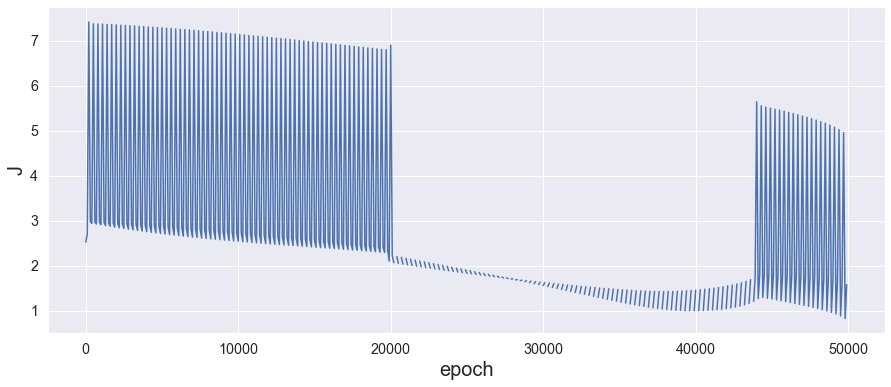

In [12]:
#Plot cost gradient descent convergence
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(it,histo)
ax.set_xlabel('epoch',fontsize=20)
ax.set_ylabel('J',fontsize=20)

In [13]:
print("Cost at theta found by gradient descent: {0:.3f}".format(histo[-1]))
print("Expected cost (approx): 0.203")
print("theta: ({0:.3f},{1:.3f},{2:.3f})".format(theta[0], theta[1], theta[2]))
print("Expected theta (approx): (-25.161,0.206,0.201)")

Cost at theta found by gradient descent: 1.582
Expected cost (approx): 0.203
theta: (-17.442,0.124,0.089)
Expected theta (approx): (-25.161,0.206,0.201)


### Optimizing the solution
Gracient descent is a first order method that requires small time steps to avoid instabilities, and thus it requires many iterations to converge. <br />
One way to overcome this problem is to look for a method that takes into account higher derivatives of the cost function. In one dimension, if we do the taylor expansion to second order of the function $J(x_t+\epsilon)$ about $\epsilon$ we get
$$J(x_t+\epsilon)=J(x_t)+\epsilon J'(x_t)+\frac{\epsilon^2}{2}J''(x_t).$$
Now, we want to find $\epsilon^*$ such that $J(x_t+\epsilon)$ is minimum, that is
\begin{align}
    \frac{\partial}{\partial\epsilon}\left(J(x_t)+\epsilon J'(x_t)+\frac{\epsilon^2}{2}J''(x_T)\right)=J'(x_T)+\epsilon J''(x_t)=0,
\end{align}
that is
$$\epsilon^*=-\frac{J'(x_t)}{J''(x_t)},$$
so we can try to update $x$ as
$$x_{t+1}=x_t-\frac{J'(x_t)}{J''(x_t)}.$$
In $n$ dimensions the update rule will be
$$\vec{x}_{t+1}=\vec{x}_t-H(\vec{x}_t)^{-1}\nabla J(\vec{x}_t),$$
where 
$$H(\vec{x})=\left(\begin{array}{cccc}\frac{\partial^2J}{\partial x_1^2} & \frac{\partial^2J}{\partial x_1\partial x_2} & \cdots & \frac{\partial^2J}{\partial x_1\partial x_n}\\ \frac{\partial^2J}{\partial x_2\partial x_1} & \frac{\partial^2J}{\partial x_2^2} & \cdots & \frac{\partial^2J}{\partial x_2\partial x_n}\\ \vdots & \vdots & \ddots & \vdots\\ \frac{\partial^2J}{\partial x_n\partial x_1} & \frac{\partial^2J}{\partial x_2\partial x_n} & \cdots & \frac{\partial^2J}{\partial x_n^2}\\ \end{array}\right)$$
is the Hessian matrix. <br />
Although this method takes much less iterations than the gradient descent when optimizong a convex function, and does not have the problem of having to choose a convergence parameter, the computation of the Hessian and its inverse takes a number of operations of order $O(n^3)$. One way to avoid having to compute the Hessian is to do a first order approximation $B$ for the second derivative of the function
$$B_{t+1}\cdot(\vec{x}_{t+1}-\vec{x}_t)=\nabla J(\vec{x}_{t+1})-\nabla J(\vec{x}_t),$$
that is uptated on each iteration. Unfortunately, save for the one dimensional case, we have more equations than components, and further constraints have to be imposed to solve the system. An algorithm called BFGS solves this by asking for $B$ to be symetric and also to minimize the Frobenius norm $||B_{t+1}-B_t||$, where
$$||A||=\sqrt{\sum_i\sum_jA_{i,j}^2}.$$
The BFGS algorithm is implemented in scipy.optimize.fmin_bfgs().

In [14]:
theta_in = np.zeros(X.shape[1])
theta_min = fmin_bfgs(J, theta_in, grad_J, args=(X, y))

Optimization terminated successfully.
         Current function value: 0.204557
         Iterations: 22
         Function evaluations: 30
         Gradient evaluations: 30


<ipython-input-7-3af144915580>:17: RuntimeWarning: divide by zero encountered in log
  logh1 = np.log(hvec1)
<ipython-input-7-3af144915580>:21: RuntimeWarning: invalid value encountered in matmul
  dot2 = np.matmul(y1.T,logh1)


In [16]:
print("Cost at theta found by BFGS: {0:.3f}".format(J(theta_min,X,y)))
print("Expected cost (approx): 0.203")
print("theta: ({0:.3f},{1:.3f},{2:.3f})".format(theta_min[0], theta_min[1], theta_min[2]))
print("Expected theta (approx): (-25.161,0.206,0.201)")

Cost at theta found by BFGS: 0.205
Expected cost (approx): 0.203
theta: (-24.870,0.203,0.200)
Expected theta (approx): (-25.161,0.206,0.201)


In [30]:
#The boundary is found when logistic(theta_min, x) = 0.5
# which is the same as x . theta_min = 0
def decisionBoundary(theta, xin, xfin, N):
    Dx = (xfin-xin) / N
    a = theta[1] / theta[2]
    b = theta[0] / theta[2]
    boundary = []
    for x in np.arange(xin, xfin+1, Dx):
        boundary.append([x, -a*x-b])
    return pd.DataFrame(boundary, columns=['x1', 'x2'])

In [34]:
bdf = decisionBoundary(theta_min, 30, 100, 10)

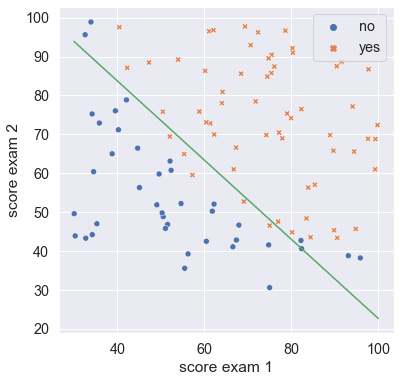

In [35]:
fig0, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, ax=ax, x='score exam 1', y='score exam 2', hue='admitted', style='admitted')
sns.lineplot(data=bdf, ax=ax, x='x1', y='x2', color='g')

## ============== Part 4: Predict and Accuracies ==============

In [37]:
#Assume a student with a score of 45 in the first exam and 85 in the second exam.
# With what probability would she be admitted?
prob = logistic(theta_min.reshape(3,1), [1, 45, 85])
print("For a student with scores 45 and 85, we predict an admission probability of {0:.3f}".format(prob))
print("Expected value: 0.775 +/- 0.002")

For a student with scores 45 and 85, we predict an admission probability of 0.781
Expected value: 0.775 +/- 0.002


In [50]:
#Accuracy
def predict_acc(theta, X, y):
    tot = 0
    for i in range(X.shape[0]):
        py = 1 if logistic(theta, X[i]) > 0.5 else 0
        tot += 1 if py == y[i] else 0
    return tot / X.shape[0]

In [51]:
p = predict_acc(theta_min, X, y)
print("Train accuracy: {0:.2f}".format(p))
print("Expected accuracy (approx): 0.89")

Train accuracy: 0.89
Expected accuracy (approx): 0.89
